<a href="https://colab.research.google.com/github/visiont3lab/covid-mask-classifier/blob/master/Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%cd /content/drive/My Drive/Classification-Project

/content/drive/My Drive/Classification-Project


In [ ]:
!git clone https://github.com/visiont3lab/covid-mask-classifier.git

Cloning into 'covid-mask-classifier'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 1045 (delta 10), reused 16 (delta 3), pack-reused 1013
Receiving objects: 100% (1045/1045), 83.18 MiB | 16.63 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (1014/1014), done.


In [3]:
%cd covid-mask-classifier/

/content/drive/My Drive/Classification-Project/covid-mask-classifier


In [4]:
import os
import cv2 #opencv-python
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, auc,precision_score,recall_score
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import joblib
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.decomposition import PCA
from keras.preprocessing.image import ImageDataGenerator  

Using TensorFlow backend.


In [5]:
!rm -rf dataset-aug/mask/ && rm -rf dataset-aug/no-mask/

In [7]:
name = "mask"
folder_path = "dataset/" # da quale cartella vogliamo legger
folder_path_augmented = "dataset-aug/" + name
try: 
    os.mkdir(folder_path_augmented) 
except OSError as error: 
    print(error) 

IMG_SIZE = (32,32) # W, H
BATCH_SIZE = 250

def my_generator(batch_size):
    SEED=42  
    images_generator = ImageDataGenerator(
            #rescale=1./255,
            brightness_range=(0.3, 1.0),
            vertical_flip=False,
            horizontal_flip=True,
            width_shift_range=0.12, #0.05,
            height_shift_range=0.12, #0.05,
            rotation_range=10, #2,
            zoom_range=0.15
            ).flow_from_directory(
                directory=folder_path,
                classes=[name],
                target_size=IMG_SIZE,
                color_mode="rgb", # grayscale
                batch_size=batch_size,
                class_mode="categorical",
                shuffle=True,
                seed=SEED
            )
        #.flow(logo, logo, batch_size, seed=SEED)
    while True:
        images_aug_batch,_ = images_generator.next()
        yield images_aug_batch  


for j in range(0,2):
    images_aug_batch  = next(my_generator(BATCH_SIZE))
    print(images_aug_batch.shape)
    for i in range(0,images_aug_batch.shape[0]):
        im = cv2.cvtColor(images_aug_batch[i,:,:,:], cv2.COLOR_BGR2RGB)
        cv2.imwrite(folder_path_augmented + "/" + str(j) + "_" + str(i) + ".png", im)
        #im = cv2.resize(im, (128,128))
        #cv2_imshow(im)



Found 499 images belonging to 1 classes.
(250, 32, 32, 3)
Found 499 images belonging to 1 classes.
(250, 32, 32, 3)


In [8]:
def load_data():
    folder_path = "dataset-aug"
    channel = 3
    size = 32

    ## -----------  Read Data
    class_name =  ["mask", "no-mask"]

    num_classes = len(class_name)
    X = []
    Y = []
    for i in range(0,num_classes):
        fpath = os.path.join(folder_path, class_name[i])
        for name in os.listdir(fpath):
            path_read_im = os.path.join(fpath, name)
            #print(path_read_im)
            im = None
            if channel==3: 
                im = cv2.imread(path_read_im,1) # COLOR
            else:
                im = cv2.imread(path_read_im,0) # GRAY

            im = cv2.resize(im, (size,size), interpolation = cv2.INTER_AREA)
            im = im.reshape(size*size*channel)

            X.append(im)
            Y.append(i)

    X = np.array(X, dtype="float32")
    Y = np.array(Y, dtype="float32")

    print(X.shape)
    print(Y.shape)
    return X,Y

X,Y = load_data()

(1000, 3072)
(1000,)


In [73]:
def compare_models(X,Y):
    # user variables to tune
    seed    = 5
    folds   = 5 # 10 = 10%, 5 = 20% for testing
    #5-fold cross validation. This means that 20% of the data is used for testing, this is usually pretty accurate.
    metric  ="roc_auc"

    sc = MinMaxScaler() # 0-1
    X = sc.fit_transform(X)
    print(X.shape)

    pca = PCA(n_components=0.99)
    X = pca.fit_transform(X)
    print(X.shape)

    # hold different regression models in a single dictionary
    models = {}
    models["GradientBoost"]        = GradientBoostingClassifier() #n_estimators=50)
    models["RandomForest"]         = RandomForestClassifier() #n_estimators=100)
    #models["NaiveBayes"]           = GaussianNB()
    models["Logistic"]             = LogisticRegression()
    models["SVC"]                  = SVC(probability=True)

    # 10-fold cross validation for each model
    model_results = []
    model_names   = []
    for model_name in models:
        model   = models[model_name]
        k_fold  = KFold(n_splits=folds, random_state=seed,shuffle=True)
        results = cross_val_score(model, X, Y, cv=k_fold, scoring=metric)

        model_results.append(results)
        model_names.append(model_name)
        print("{}: {}, {}".format(model_name, round(results.mean(), 3), round(results.std(), 3)))

compare_models(X,Y)

(999, 3072)
(999, 374)
GradientBoost: 0.989, 0.007
RandomForest: 0.972, 0.004
Logistic: 0.991, 0.007
SVC: 0.996, 0.004


In [9]:
def save_model_joblib(inp_name,inp_clf):
    joblib.dump(inp_clf, inp_name) 
    
def train(X,Y):
    X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=0.2, random_state=42)

    pipeline = Pipeline([
        ("sc", MinMaxScaler()), # 0-1 features
        #('polinomial', PolynomialFeatures(degree=3)),
        ("pca", PCA(n_components=0.99)),
        ("model", SVC(probability=True) ) # Probability truw slow down dataset
    ])

    tuned_parameters = [
                {'model__kernel': ['rbf'],  'model__C': [1,10, 100, 1000]},
                {'model__kernel': ['linear'], 'model__C': [1, 10, 100, 1000]},
                #{'model__kernel' : ['poly'], 'model__degree' : [2,3,4] ,'model__C': [1,10, 100, 1000]}
            ]
    
    grid_search = RandomizedSearchCV(
        pipeline, tuned_parameters, scoring='f1_macro'
    )

    # Train
    grid_search.fit(X_train,Y_train)

    # Score
    score = grid_search.best_estimator_.score(X,Y)
    print("f1_weighted score : ", score)



    save_model_joblib("model.pkl", grid_search.best_estimator_)
    return grid_search.best_estimator_

train(X,Y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


f1_weighted score :  1.0


Pipeline(steps=[('sc', MinMaxScaler()), ('pca', PCA(n_components=0.99)),
                ('model', SVC(C=100, probability=True))])

In [ ]:
def load_model_joblib(inp_name):
    # Load a pipeline
    my_model_loaded = joblib.load(inp_name)
    return my_model_loaded

def test_pickle(X):
    size=32
    channel=3
    model = load_model_joblib("model.pkl")
    label = model.predict(X)
    res = model.predict_proba(X)
     
    for i in range(0, res.shape[0]):
        mask_perc = res[i][0]
        no_mask_perc = res[i][1]
        im = X[i,:].reshape(size,size,channel)
        im = cv2.resize(im, (128,128))
        #cv2.putText(im, "Mask: " + str(np.round(mask_perc,1))  ,(10,30), cv2.FONT_HERSHEY_COMPLEX,1, (0,255,0),1)
        cv2_imshow(np.uint8(im))
        print( "Mask: " + str(np.round(mask_perc,1)) )
    
#test_pickle(X)

In [10]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


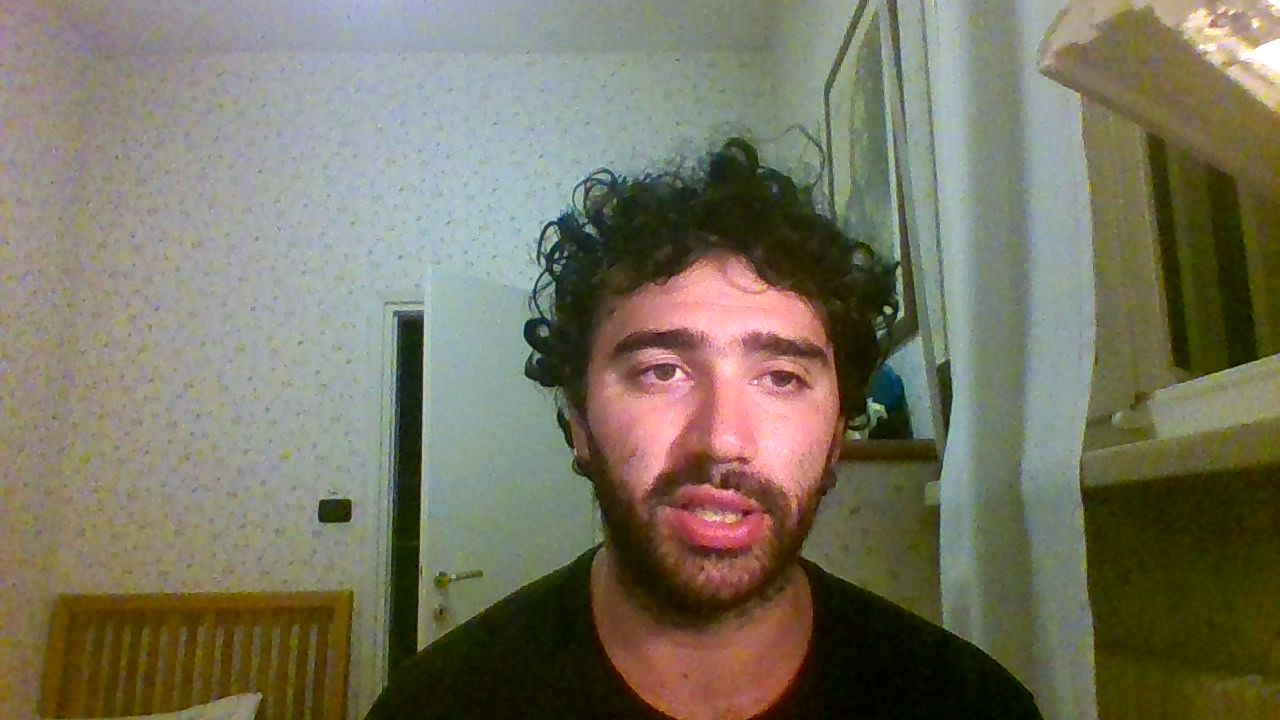

In [117]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [120]:
def load_model_joblib(inp_name):
    # Load a pipeline
    my_model_loaded = joblib.load(inp_name)
    return my_model_loaded

# Face detection
class FaceMaskDetector:
	
    def __init__(self):
        self.model_face = cv2.CascadeClassifier('models/haarcascade/haarcascade_frontalface_default.xml')
        self.model_mask = load_model_joblib("model.pkl")

    def run(self, image):
        faces = self.model_face.detectMultiScale(image, 1.2,5)
        for (x,y,w,h) in faces:
            #print("Face found")
            roi = image[y:y+h,x:x+w]
            # HA oppure non  ha la mascherina
            roi_resized = cv2.resize(roi,(32,32))
            #print(roi_resized.shape)
            roi_resized = roi_resized[np.newaxis,:,:,:]
            #print(roi_resized.shape)
            vec = roi_resized.reshape(1,32*32*3)
            #print(vec.shape)
            res = self.model_mask.predict_proba(vec)  
            #print(res.shape)          
            mask_perc = res[0][0]
            #no_mask_perc = res[0][1]
            print( "Mask: " + str(np.round(mask_perc,1)) )

            #cv2.imwrite(self.save_folder+str(self.c)+".png", roi)
            cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
            cv2_imshow(image)

    def run_roi(self, roi):
        # HA oppure non  ha la mascherina
        roi_resized = cv2.resize(roi,(32,32))
        #print(roi_resized.shape)
        roi_resized = roi_resized[np.newaxis,:,:,:]
        #print(roi_resized.shape)
        vec = roi_resized.reshape(1,32*32*3)
        #print(vec.shape)
        res = self.model_mask.predict_proba(vec)  
        #print(res.shape)          
        mask_perc = res[0][0]
        #no_mask_perc = res[0][1]
        print( "Mask: " + str(np.round(mask_perc,1)) )
        cv2_imshow(roi)

class FaceMaskDetectorDeep:
	
    def __init__(self):
        prototxtPath = os.path.join("models","mobilenet", "deploy.prototxt")
        weightsPath = os.path.join("models","mobilenet","res10_300x300_ssd_iter_140000.caffemodel")
        self.net = cv2.dnn.readNet(prototxtPath, weightsPath)
        self.confidence = 0.4
        self.model_mask = load_model_joblib("model.pkl")

    def run(self, image):
        orig = image.copy()
        (h, w) = image.shape[:2]

        blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))
        self.net.setInput(blob)
        detections = self.net.forward()

        for i in range(0, detections.shape[2]):
            # extract the confidence (i.e., probability) associated with  the detection
            confidence = detections[0, 0, i, 2]

            # filter out weak detections by ensuring the confidence is
            # greater than the minimum confidence
            if confidence > self.confidence:
                # compute the (x, y)-coordinates of the bounding box for
                # the object
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                x = startX
                y= startY
                w = endX-startX
                h = endY -startY

                # ensure the bounding boxes fall within the dimensions of
                # the frame
                #(startX, startY) = (max(0, startX), max(0, startY))
                #(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

                # extract the face ROI, convert it from BGR to RGB channel
                # ordering, resize it to 224x224, and preprocess it

                roi = image[y:y+h,x:x+w]

                # HA oppure non  ha la mascherina
                roi_resized = cv2.resize(roi,(32,32))
                #print(roi_resized.shape)
                roi_resized = roi_resized[np.newaxis,:,:,:]
                #print(roi_resized.shape)
                vec = roi_resized.reshape(1,32*32*3)
                #print(vec.shape)
                res = self.model_mask.predict_proba(vec)  
                #print(res.shape)          
                mask_perc = res[0][0]
                #no_mask_perc = res[0][1]
                print( "Mask: " + str(np.round(mask_perc,1)) )

                #cv2.imwrite(self.save_folder+str(self.c)+".png", roi)
                cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
                cv2_imshow(image)

 

Mask: 1.0


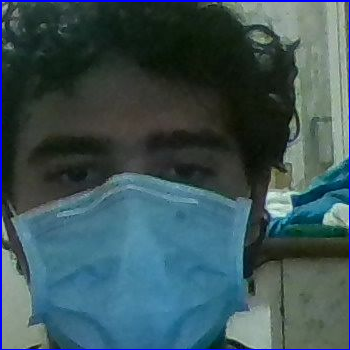

In [88]:
im = cv2.imread("photo.jpg",1)
x = 500
y = 160
w = 350
h = 350
cv2.rectangle(im,(x,y),(x+w,y+h),(255,0,0),2)
roi = im[y:y+h,x:x+w]
cf = FaceMaskDetector()
cf.run_roi(roi)
#cv2_imshow(im)

Mask: 0.0


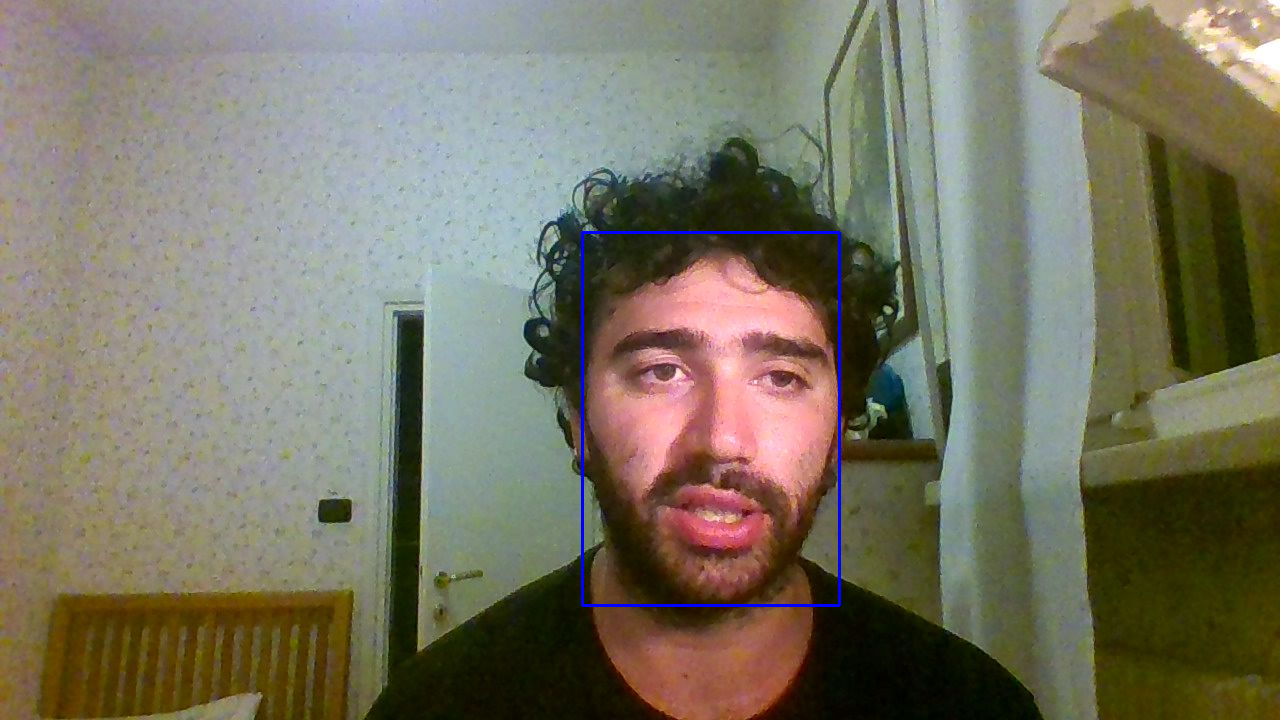

In [122]:
#cf = FaceMaskDetector()
cf = FaceMaskDetectorDeep()
im = cv2.imread("photo.jpg",1)
cf.run(im)